Source vector is calculated separately


In [ ]:
!pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18168 sha256=58e6165e7849ccdbb921f1b8725327a3bf095233659fdbb10833e74c18e2a3e3
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [ ]:
import scipy.io
import numpy as np
from pyDOE import lhs
import tensorflow as tf
import time
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib as mpl
import matplotlib.pyplot as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.13.0


In [ ]:
""""""""""" Original physical parameters """""""""""
# External source sineburst excitation parameters
original_Lx = original_Ly = 0.3 # x-length and y-length of the steel plate[m]
original_c = 4773.343 # [m/s]  wave propagation speed in steel plate, v = sqrt(E/rho)
original_rho = 7900 # [kg/m^3] density of steel plate
original_fex = 120000 # frequency in Hz used in excitation
original_Tex = 1/original_fex
cycles = 5
original_dt = original_Tex /40  # in seconds
original_tsim = 1.2*original_Lx/2/original_c; # total simulation time
print('original_dt : ', original_dt, ' original_tsim : ', original_tsim)
original_Vamp = 10e-9;


""""""""""" Scaled parameters between [0, 1] """""""""""""""
scaled_Lx = scaled_Ly = 1.0 # scaled x-length and y-length of the steel plate
scaling_length_factor = original_Lx*scaled_Lx
beta = scaling_length_factor
print('Scaled length parameter (beta) : ', beta)
scaled_tsim = 1.0
scaling_time_factor = original_tsim*scaled_tsim
alpha = scaling_time_factor
print('Scaled time parameters (alpha) : ', alpha)
scaled_c = original_c*(alpha/beta)
print('Scaled velocity: ', scaled_c)
scaled_fex = original_fex * alpha;
scaled_Tex = 1/scaled_fex; # scaled time period
scaled_dt = scaled_Tex * scaled_tsim/40;
scaled_Vamp = original_Vamp*scaling_length_factor
print('scaled_dt : ', scaled_dt, ' scaled_tsim : ', scaled_tsim)

lb = np.array([0.0, 0.0, 0.0,0.0,0.0]) # (x_0,y_0,t_0)

ub =  np.array([1.0, 1.0, 1.0, 1.0, 1.0])  # (x_n,y_n,t_n)


original_dt :  2.0833333333333333e-07  original_tsim :  3.770942083986003e-05
Scaled length parameter (beta) :  0.3
Scaled time parameters (alpha) :  3.770942083986003e-05
Scaled velocity:  0.6
scaled_dt :  0.005524702546296296  scaled_tsim :  1.0


In [ ]:
# Creating source at the center of the plate
def DelSrcPT(XYT_c, xc, yc, r):
  dst = np.array([((xyt[0]-xc)**2 + (xyt[1]-yc)**2)**0.5 for xyt in XYT_c])
  return XYT_c[dst>r, :]

def GenCirclePT(xc, yc, r, N_PT):
  theta = np.linspace(0.0, np.pi*2.0, N_PT)
  xx = np.multiply(r, np.cos(theta)) + xc
  yy = np.multiply(r, np.sin(theta)) + yc
  xx = xx.flatten()[:, None]
  yy = yy.flatten()[:, None]
  theta = theta.flatten()[:,None]
  return xx, yy, theta

# Properties of source
xc_src = scaled_Lx/2 # 0.15
yc_src = scaled_Ly/2 # 0.15
r_src = scaled_Lx/64 # 0.00467 ~ 0.005 # Lx/128 ~ 0.00234

# Collocation points
N_pde = 20000
XYT_c = lb + (ub-lb)*lhs(5, N_pde)
XYT_c_ext = np.array([xc_src - r_src - 0.01, yc_src - r_src - 0.01, 0.0, 0.0, 0.0]) + np.array([2*(r_src + 0.001), 2*(r_src + 0.001), scaled_tsim, 1.0, 1.0])*lhs(5, 10000)
XYT_c = np.concatenate((XYT_c, XYT_c_ext), axis = 0)
XYT_c = DelSrcPT(XYT_c, xc = xc_src, yc = yc_src, r = r_src)
xx , yy, theta = GenCirclePT(xc = xc_src, yc=yc_src, r=r_src, N_PT=100)
tt = np.linspace(0, scaled_tsim, 353)
x_SRC, t_SRC = np.meshgrid(xx, tt)
y_SRC, _     = np.meshgrid(yy, tt)
x_SRC = x_SRC.flatten()[:, None]
y_SRC = y_SRC.flatten()[:, None]
t_SRC = t_SRC.flatten()[:, None]
PI = np.pi
sineburst = scaled_Vamp * np.sin(2*PI*scaled_fex*(t_SRC)) * np.sin(PI*scaled_fex/cycles*t_SRC)**2
u_SRC = sineburst*((x_SRC-xc_src)**2/r_src**2 + (y_SRC-yc_src)**2/r_src**2)

dx_SRC = np.ones((np.size(x_SRC),1))*0.4
dy_SRC = np.ones((np.size(y_SRC),1))*0.3

SRC = np.concatenate((x_SRC, y_SRC, t_SRC, dx_SRC, dy_SRC), 1)


In [ ]:
# keep it in original dimensions

In [ ]:
np.max(XYT_c_ext)

0.9999865968786813

In [ ]:
x_star.min()

35300

In [ ]:
np.shape(u_SRC)

(35300, 1)

In [ ]:
np.shape(XYT_c)

(25649, 5)

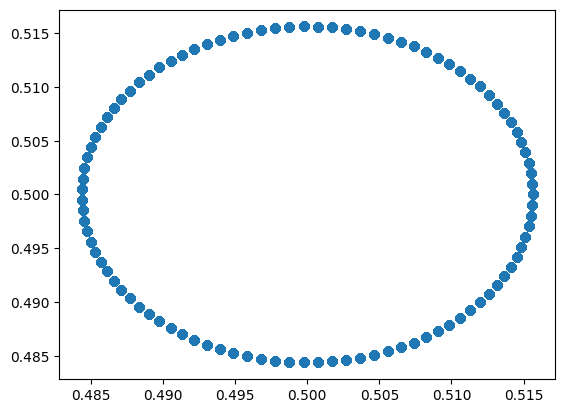

In [ ]:
plt.scatter(x_SRC, y_SRC, marker='o', alpha=0.5 )
plt.show()

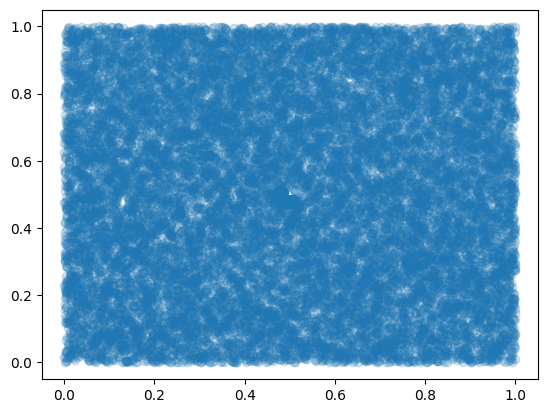

In [ ]:
plt.scatter(XYT_c[:, 0], XYT_c[:, 1], marker='o', alpha=0.2 )
plt.show()

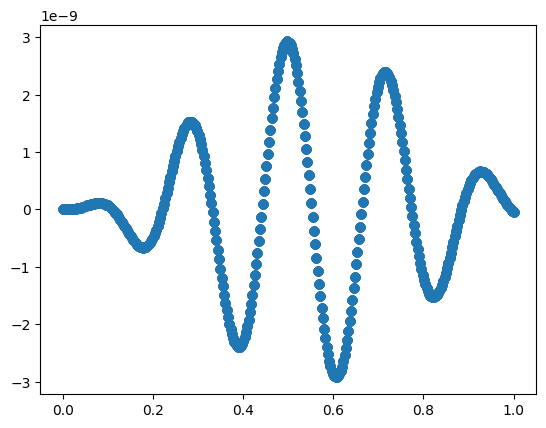

In [ ]:
plt.scatter(t_SRC, sineburst, marker='o', alpha=0.2 )
plt.show()

In [ ]:
""""""""""" Imported scaled data from MATLAB """""""""""""""
# Load Data
data = scipy.io.loadmat('wave2d_damage_scaled.mat')
disp_data = data['saved_dis'] # 151 x 151 x 182 # actual dimension
scaled_disp_data = data['scaled_w'] # 151 x 151 x 182 # scaled dimension
t_data = data['time_data'] # 1 x 182
x_data = data['x'] # 1 x 151
y_data = data['y'] # 1 x 151
print('disp_data : ', np.shape(disp_data))
print('scaled_disp_data : ', np.shape(scaled_disp_data))
print('t_data : ', np.shape(t_data))
print('x_data : ', np.shape(x_data))
print('y_data : ', np.shape(y_data))

disp_data :  (151, 151, 182)
scaled_disp_data :  (151, 151, 182)
t_data :  (1, 182)
x_data :  (1, 151)
y_data :  (1, 151)


In [ ]:
# Modifying shapes of input MATLAB data to be compatible for training
""""""""""" Space co-ordinates """""""""""""""
x_data = x_data.T # 151 x 1
y_data = y_data.T # 151 x 1
X,Y = np.meshgrid(x_data,y_data)
X_Y_data = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
print('X_Y_data : ',np.shape(X_Y_data)) # 22801 x 2

""""""""""" Displacement field (actual) """""""""""""""
disp_data = disp_data.reshape(-1,182)
print('disp_data : ',np.shape(disp_data))  # 22801 x 182


""""""""""" Displacement field (scaled) """""""""""""""
scaled_disp_data = scaled_disp_data.reshape(-1,182)
print('scaled_disp_data : ',np.shape(scaled_disp_data))  # 22801 x 182

#-------------------------------------------------------------------------------
# Lets set equal shape for all input and output data
TT= np.tile(t_data,(22801, 1)) # repeats time_data row-wise
print('t_star : ',np.shape(TT))
XX= np.tile(X_Y_data[:,0:1],(1,182)) # repeats x_star column-wise
print('x_star : ',np.shape(XX))
YY= np.tile(X_Y_data[:,1:2],(1,182)) # repeats y_star column-wise
print('y_star : ',np.shape(YY))
UU = disp_data
print('u_star : ',np.shape(UU))
UU_scaled = scaled_disp_data
print('u_star_scaled : ',np.shape(UU_scaled))

# Reshape input and outputs as column vector
print('After reshaping to column vectors : ')
t_star = np.reshape(TT,(-1,1))
print('t_star : ',np.shape(t_star))
x_star = np.reshape(XX,(-1,1))
print('x_star : ',np.shape(x_star))
y_star = np.reshape(YY,(-1,1))
print('y_star : ',np.shape(y_star))
u_star = np.reshape(UU,(-1,1))
print('u_star : ',np.shape(u_star))
u_star_scaled = np.reshape(UU_scaled,(-1,1))
print('u_star_scaled : ',np.shape(u_star_scaled))

""""""""""" Damage location parameters """""""""""""""
damage_x = np.zeros((151,1))
damage_x[0:151] = 0.4

damage_y = np.zeros((151,1))
damage_y[0:151] = 0.3

Dx,Dy = np.meshgrid(damage_x,damage_y)
Dx_Dy_data = np.hstack((Dx.flatten()[:,None], Dy.flatten()[:,None]))
print('Dx_Dy_data : ',np.shape(Dx_Dy_data)) # 22801 x 2

dx_star = np.tile(Dx_Dy_data [:,0:1],(1,182)) # repeats dx_star column-wise
print('dx_star : ',np.shape(dx_star))
dy_star = np.tile(Dx_Dy_data [:,1:2],(1,182)) # repeats dy_star column-wise
print('dy_star : ',np.shape(dy_star))

dx_star = np.reshape(dx_star,(-1,1))
print('dx_star after reshaping : ',np.shape(dx_star))
dy_star = np.reshape(dy_star,(-1,1))
print('dy_star after reshaping : ',np.shape(dy_star))

""""""""""" Damage size parameters """""""""""""""
damage_sigma_x = np.zeros((151,1))
damage_sigma_x[0:151] = 0.03

damage_sigma_y = np.zeros((151,1))
damage_sigma_y[0:151] = 0.03

Dsigma_x, Dsigma_y = np.meshgrid(damage_sigma_x,damage_sigma_y)
Dx_Dy_sigma_data = np.hstack((Dsigma_x.flatten()[:,None], Dsigma_y.flatten()[:,None]))
print('Dx_Dy_sigma_data : ',np.shape(Dx_Dy_sigma_data)) # 22801 x 2

d_sigma_x_star = np.tile(Dx_Dy_sigma_data [:,0:1],(1,182)) # repeats dx_star column-wise
print('d_sigma_x_star : ',np.shape(d_sigma_x_star))
d_sigma_y_star = np.tile(Dx_Dy_sigma_data [:,1:2],(1,182)) # repeats dy_star column-wise
print('d_sigma_y_star : ',np.shape(d_sigma_y_star))

d_sigma_x_star = np.reshape(d_sigma_x_star,(-1,1))
print('d_sigma_x_star after reshaping : ',np.shape(d_sigma_x_star))
d_sigma_y_star = np.reshape(d_sigma_y_star,(-1,1))
print('d_sigma_y_star after reshaping : ',np.shape(d_sigma_y_star))

X_Y_data :  (22801, 2)
disp_data :  (22801, 182)
scaled_disp_data :  (22801, 182)
t_star :  (22801, 182)
x_star :  (22801, 182)
y_star :  (22801, 182)
u_star :  (22801, 182)
u_star_scaled :  (22801, 182)
After reshaping to column vectors : 
t_star :  (4149782, 1)
x_star :  (4149782, 1)
y_star :  (4149782, 1)
u_star :  (4149782, 1)
u_star_scaled :  (4149782, 1)
Dx_Dy_data :  (22801, 2)
dx_star :  (22801, 182)
dy_star :  (22801, 182)
dx_star after reshaping :  (4149782, 1)
dy_star after reshaping :  (4149782, 1)
Dx_Dy_sigma_data :  (22801, 2)
d_sigma_x_star :  (22801, 182)
d_sigma_y_star :  (22801, 182)
d_sigma_x_star after reshaping :  (4149782, 1)
d_sigma_y_star after reshaping :  (4149782, 1)


In [ ]:
def trainingdata(N_u_ic, N_u_bc):

  # Initial condition
  t_b0 = t_star[t_star==t_star.min()][:,None]
  x_b0 = x_star[t_star == t_star.min()][:,None]
  y_b0 = y_star[t_star == t_star.min()][:,None]
  dx_b0 = dx_star[t_star == t_star.min()][:,None]
  dy_b0 = dy_star[t_star == t_star.min()][:,None]
  X_b0 = np.concatenate([x_b0,y_b0,t_b0,dx_b0,dy_b0],1)  # concatenate  x_b0, y_b0,t_b0, dx_b0, dy_b0
  print('X_b0 : ', np.shape(X_b0))
  u_b0 = u_star[t_star == t_star.min()][:,None]
  print('t_b0 : ', np.shape(t_b0),'x_b0 : ', np.shape(x_b0),
        'y_b0 : ', np.shape(y_b0),'dx_b0 : ', np.shape(dx_b0),
        'dy_b0 : ', np.shape(dy_b0),'u_b0 : ', np.shape(u_b0) )


  # Boundary condition - left side <--- 151 x 16 = (left boubary space grid points x timesteps)
  t_b1 = t_star[x_star==x_star.min()][:,None]
  x_b1 = x_star[x_star == x_star.min()][:,None]
  y_b1 = y_star[x_star == x_star.min()][:,None]
  dx_b1 = dx_star[x_star == x_star.min()][:,None]
  dy_b1 = dy_star[x_star == x_star.min()][:,None]
  X_b1 = np.concatenate([x_b1,y_b1,t_b1,dx_b1,dy_b1],1)  # concatenate x_b1, y_b1, t_b1, dx_b1, dy_b1
  print('X_b1 : ', np.shape(X_b1))
  u_b1 = u_star[x_star == x_star.min()][:,None]
  print('t_b1 : ', np.shape(t_b1),'x_b1 : ', np.shape(x_b1),
        'y_b1 : ', np.shape(y_b1),'dx_b1 : ', np.shape(dx_b1),
        'dy_b1 : ', np.shape(dy_b1),'u_b1 : ', np.shape(u_b1))

  # Boundary condition - right side <--- 151 x 16 = (right boubary space grid points x timesteps)
  t_b2 = t_star[x_star==x_star.max()][:,None]
  x_b2 = x_star[x_star == x_star.max()][:,None]
  y_b2 = y_star[x_star == x_star.max()][:,None]
  dx_b2 = dx_star[x_star == x_star.max()][:,None]
  dy_b2 = dy_star[x_star == x_star.max()][:,None]
  X_b2 = np.concatenate([x_b2,y_b2,t_b2,dx_b2,dy_b2],1)  # concatenate  x_b2, y_b2, t_b2, dx_b2, dy_b2
  print('X_b2 : ', np.shape(X_b2))
  u_b2 = u_star[x_star == x_star.max()][:,None]
  print('t_b2 : ', np.shape(t_b2),'x_b2 : ', np.shape(x_b2),
        'y_b2 : ', np.shape(y_b2),'dx_b2 : ', np.shape(dx_b2),
        'dy_b2 : ', np.shape(dy_b2),'u_b2 : ', np.shape(u_b2))

  # Boundary condition - bottom side <--- 151 x 16 = (bottom boubary space grid points x timesteps)
  t_b3 = t_star[y_star==y_star.min()][:,None]
  x_b3 = x_star[y_star == y_star.min()][:,None]
  y_b3 = y_star[y_star == y_star.min()][:,None]
  dx_b3 = dx_star[y_star == y_star.min()][:,None]
  dy_b3 = dy_star[y_star == y_star.min()][:,None]
  X_b3 = np.concatenate([x_b3,y_b3,t_b3,dx_b3,dy_b3],1)  # concatenate x_b3, y_b3, t_b3, dx_b3, dy_b3
  print('X_b3 : ', np.shape(X_b3))
  u_b3 = u_star[y_star == y_star.min()][:,None]
  print('t_b3 : ', np.shape(t_b3),'x_b3 : ', np.shape(x_b3),
        'y_b3 : ', np.shape(y_b3),'dx_b3 : ', np.shape(dx_b3),
        'dy_b3 : ', np.shape(dy_b3),'u_b3 : ', np.shape(u_b3))

  # Boundary condition - top side <--- 151 x 16 = (top boubary space grid points x timesteps)
  t_b4 = t_star[y_star == y_star.max()][:,None]
  x_b4 = x_star[y_star == y_star.max()][:,None]
  y_b4 = y_star[y_star == y_star.max()][:,None]
  dx_b4 = dx_star[y_star == y_star.max()][:,None]
  dy_b4 = dy_star[y_star == y_star.max()][:,None]
  X_b4 = np.concatenate([x_b4,y_b4,t_b4,dx_b4,dy_b4],1)  # concatenate x_b4, y_b4, t_b4, dx_b4, dy_b4
  print('X_b4 : ', np.shape(X_b4))
  u_b4 = u_star[y_star == y_star.max()][:,None]
  print('t_b4 : ', np.shape(t_b4),'x_b4 : ', np.shape(x_b4),
        'y_b4 : ', np.shape(y_b4),'dx_b4 : ', np.shape(dx_b4),
        'dy_b4 : ', np.shape(dy_b4),'u_b4 : ', np.shape(u_b4))


  #-----------------Initial condition data points-------------------------------
  all_X_u_ic_train = np.vstack([X_b0])  # (,5) = (x,y,t,dx,dy)
  print('all_X_u_ic_train : ', np.shape(all_X_u_ic_train))
  all_u_ic_train = np.vstack([u_b0]) # (,1) = (u)
  print('all_u_ic_train : ', np.shape(all_u_ic_train))

  #choose random N_u_ic points for training for IC
  idx = np.random.choice(all_X_u_ic_train.shape[0], N_u_ic, replace=False)

  X_u_ic_train = all_X_u_ic_train[idx,:] # choose indices from set 'idx' (x,t)
  print('X_u_ic_train from random sampling : ', np.shape(X_u_ic_train))
  u_ic_train = all_u_ic_train[idx,:]
  print('u_ic_train from random sampling : ', np.shape(u_ic_train))

  #-------------------Boundary condition data points----------------------------

  all_X_u_bc_train = np.vstack([X_b1, X_b2, X_b3, X_b4])  # (,5) = (x,y,t,dx,dy)
  print('all_X_u_bc_train : ', np.shape(all_X_u_bc_train))
  all_u_bc_train = np.vstack([u_b1, u_b2, u_b3, u_b4]) # (,1) = (u)
  print('all_u_bc_train : ', np.shape(all_u_bc_train))

  #choose random N_u_bc points for training at boundary points
  idx = np.random.choice(all_X_u_bc_train.shape[0], N_u_bc, replace=False)
  X_u_bc_train = all_X_u_bc_train[idx,:] # choose indices from set 'idx' (x,t)
  print('X_u_bc_train from random sampling : ', np.shape(X_u_bc_train))
  u_bc_train = all_u_bc_train[idx,:]
  print('u_bc_train from random sampling : ', np.shape(u_bc_train))

  # #--------------------PDE data points------------------------------------------
  # # Random sampling for PDE points as well
  # idx = np.random.choice(t_star.shape[0], N_pde, replace=False)
  # t_pde_train = t_star[idx,:]
  # x_pde_train = x_star[idx,:]
  # y_pde_train = y_star[idx,:]
  # dx_pde_train = dx_star[idx,:]
  # dy_pde_train = dy_star[idx,:]
  # u_pde_train = u_star[idx,:]
  # print('t_pde_train : ',np.shape(t_pde_train), 'x_pde_train : ', np.shape(x_pde_train), 'y_pde_train : ',np.shape(y_pde_train),
  #       'dx_pde_train : ',np.shape(dx_pde_train), 'dy_pde_train : ',np.shape(dy_pde_train),'u_pde_train : ',np.shape(u_pde_train))

  # X_pde_train = np.hstack([x_pde_train, y_pde_train, t_pde_train, dx_pde_train, dy_pde_train])
  # # adding source point - work from here
  # x_pde_train_source = np.ones((np.size(t_data),1))*scaled_Lx/2
  # y_pde_train_source =  np.ones((np.size(t_data),1))*scaled_Ly/2
  # t_pde_train_source = t_data.T
  # dx_pde_train_source = np.ones((np.size(t_data),1))*0.4
  # dy_pde_train_source = np.ones((np.size(t_data),1))*0.3
  # X_pde_train_source = np.hstack([x_pde_train_source, y_pde_train_source, t_pde_train_source, dx_pde_train_source, dy_pde_train_source])

  # #source_point = np.array([scaled_Lx/2, scaled_Ly/2, 0.0, 0.4, 0.3])
  # X_pde_train = np.vstack([X_pde_train, X_pde_train_source])
  # print('X_f_train from random sampling : ', np.shape(X_pde_train))


  return X_u_ic_train, u_ic_train, X_u_bc_train, u_bc_train

In [ ]:
class ParametricModel_Scaled(tf.Module):

  def __init__(self, layers, name=None):
    self.W = [] # weights and biases <----- initializing the array
    self.parameters = 0 # total number of parameters <----- initializing the variable

    for i in range(len(layers)-1):
      input_dim = layers[i]
      #print('input_dim : ', input_dim, 'in layer : ', i)
      output_dim = layers[i+1]
      #print('output_dim : ', output_dim, 'in layer : ', i)

      # Xavier standard deviation = Glorot
      std_dv = np.sqrt((2.0/(input_dim + output_dim)))
      #print('std_dv : ', std_dv, 'in layer : ', i)

      # weights = normal distribution*Xavier standard deviation + 0
      w = tf.random.normal([input_dim, output_dim], dtype='float64')*std_dv
      #print('weights with std_dv: ', w, np.shape(w))

      w = tf.Variable(w,trainable=True,name='w'+str(i+1))
      #print('weights as trainable variables: ', w, np.shape(w))

      b = tf.Variable(tf.cast(tf.zeros([output_dim]),dtype='float64'), trainable=True,name='b'+str(i+1))
      #print('biases : ',b, 'in layer : ', i)

      self.W.append(w)
      #print('W appends weights :',self.W,' in layer : ',i)
      self.W.append(b)
      #print('W appends biases :',self.W,' in layer : ',i)

      self.parameters += input_dim*output_dim + output_dim
      #print('No of parameters : ', self.parameters)

  def get_weights(self):
    parameters_1d = [] # [.....W_i,b_i,.......]
    for i in range(len(layers)-1):
      w_1d = tf.reshape(self.W[2*i],[-1]) # flatten weights
      #print('w_1d : ', w_1d, 'in layer : ',i)
      b_1d = tf.reshape(self.W[2*i+1],[-1]) # flatten biases
      #print('b_1d : ', b_1d, 'in layer : ',i)

      parameters_1d = tf.concat([parameters_1d, w_1d],axis=0) # concat weights
      #print('paramters concat weights : ', parameters_1d, np.shape(parameters_1d))
      parameters_1d = tf.concat([parameters_1d, b_1d],axis=0) # concat biases
      #print('paramters concat biases : ', parameters_1d, np.shape(parameters_1d))

    return parameters_1d

  def set_weights(self,parameters): # paramters = [.....W_i,b_i,.......]
    for i in range(len(layers)-1):
      shape_w = tf.shape(self.W[2*i]).numpy() # shape of weight tensor
      size_w = tf.size(self.W[2*i]).numpy() # size of weight tensor
      #print('shape and size of w : ',shape_w,size_w, 'in layer i : ',i)

      shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of bias tensor
      size_b = tf.size(self.W[2*i+1]).numpy() # size of bias tensor
      #print('shape and size of b : ',shape_b,size_b, 'in layer b : ',i)

      pick_w = parameters[0:size_w] # pick the weights
      #print('pick_w : ', pick_w)
      self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign
      #print('assigned weights : ', self.W[2*i].assign(tf.reshape(pick_w,shape_w)) )
      #print('parameters before deleting weights: ', parameters, np.shape(parameters))
      parameters = np.delete(parameters, np.arange(size_w),0) # delete
      #print('parameters after deleting weights: ', parameters, np.shape(parameters))

      pick_b = parameters[0:size_b] # pick the biases
      self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign
      #print('parameters before deleting biases: ', parameters, np.shape(parameters))
      parameters = np.delete(parameters, np.arange(size_b),0) # delete
      #print('parameters after deleting biases : ', parameters, np.shape(parameters))

  ## HERE YOU BUILD YOUR NETWORK
  def evaluate(self,x):  # x - inputs of neurons
    x = (x-lb)/(ub - lb)  # if x = [100,5] then a = [100,5], #feature scaling
    #print('Network input : ',np.shape(x), x)
    a = x

    for i in range(len(layers)-2):
      z = tf.add(tf.matmul(a,self.W[2*i]), self.W[2*i+1])
      #print('z : ', np.shape(z))
      a = tf.nn.tanh(z)
      #print('a : ', np.shape(a))

    a =  tf.add(tf.matmul(a,self.W[-2]),self.W[-1]) # For regression, no activation to last layer
    #print('a_last layer : ', np.shape(a))
    return a  # output of the network; y = [100,1]


  def loss_IC(self,x,y): # x = [100,5]   x - network output, y = true values
    loss_u_ic = tf.reduce_mean(tf.square(y-self.evaluate(x)))  # y_cap[100,1] - y_true[100,1]

    # implementing du_dt IC
    g = tf.Variable(x, dtype='float64', trainable=False) # (6000, 5)
    x_f = g[:,0:1] # (6000, 1)
    y_f = g[:,1:2] # (6000, 1)
    t_f = g[:,2:3] # (6000, 1)
    dx_f = g[:,3:4] # (6000, 1)
    dy_f = g[:,4:5] # (6000, 1)
    #----------------------------------------------
    with tf.GradientTape(persistent=True) as tape:
      tape.watch(t_f)
      g = tf.stack([x_f[:,0], y_f[:,0], t_f[:,0], dx_f[:,0],dy_f[:,0]],axis=1) # (6000, 5)
      z  = self.evaluate(g) # passing PDE points into network#

    u_t = tape.gradient(z,t_f)
    #print('u_t: ', tf.shape(u_t))

    loss_du_ic = tf.reduce_mean(tf.square(y-u_t))  # y_cap[100,1] - y_true[100,1]

    loss_ic = loss_u_ic + loss_du_ic

    return loss_ic

  def loss_BC(self,x,y): # x = [100,5]   x - network output, y = true values
    loss_bc = tf.reduce_mean(tf.square(y-self.evaluate(x)))  # y_cap[100,1] - y_true[100,1]
    return loss_bc

  def excitation(self,x,y,t,source_val): # Excitation source

    excitation_center = (scaled_Lx/2, scaled_Ly/2)  # center of excitation source
    # XY_s = tf.concat([x[:,0], y[:,0]], 1)

    # r = np.array([((xy[0] - excitation_center[0]) ** 2 + (xy[1] - excitation_center[1]) ** 2) ** 0.5 for xy in XY_s])

    x_dist = x.numpy().all() - excitation_center[0]
    y_dist = y.numpy().all() - excitation_center[0]
    r = np.sqrt(x_dist**2 + y_dist**2)
    #print('radius : ', r)
    excitation_radius = 0.0  # Set the excitation radius - how much does the excitation spread

    excitation = source_val
    #print('excitation : ', np.shape(excitation))
    return excitation if r < excitation_radius else 0.0
    #return excitation[r < excitation_radius,:]

  def loss_PDE(self, x_to_train_f):
    g = tf.Variable(x_to_train_f, dtype='float64', trainable=False)

    # Material parameters
    ''' E = 120 GPa and density = 7900 kg/m^3, c^2 = E/density'''
    original_E = tf.constant(value=180e9, dtype='float64')
    original_rho = tf.constant(value=7900, dtype='float64')
    E_scaled = original_E/(beta**2)
    rho_scaled = original_rho/(alpha**2)
    c_scaled = np.sqrt(E_scaled/rho_scaled) # velocity of wave propagating in medium
    beta_sqr = beta**2
    # Known damage parameters
    A = tf.constant(value=0.9, dtype='float64')
    # x_0 = y_0  = tf.constant(value=0.12, dtype='float64')
    sigma_x = sigma_y = tf.constant(value=0.03, dtype='float64')

    x_pde_scaled = g[:,0:1] # (6000, 1)
    y_pde_scaled = g[:,1:2] # (6000, 1)
    t_pde_scaled = g[:,2:3] # (6000, 1)
    x0_scaled = g[:,3:4] # (6000, 1)
    y0_scaled = g[:,4:5] # (6000, 1)


    with tf.GradientTape(persistent=True) as tape: #To compute multiple gradients over the same computation, create a gradient tape with persistent=True
      tape.watch(x_pde_scaled)
      tape.watch(y_pde_scaled)
      tape.watch(t_pde_scaled)
      tape.watch(x0_scaled)
      tape.watch(y0_scaled)

      with tf.GradientTape(persistent=True) as doubletape:
        doubletape.watch(x_pde_scaled)
        doubletape.watch(y_pde_scaled)
        doubletape.watch(t_pde_scaled)
        doubletape.watch(x0_scaled)
        doubletape.watch(y0_scaled)

        g = tf.stack([x_pde_scaled[:,0], y_pde_scaled[:,0], t_pde_scaled[:,0], x0_scaled[:,0], y0_scaled[:,0]],axis=1) # (6000, 5)
        #print('g: ', np.shape(g))

        u_scaled  = self.evaluate(g) # passing PDE points into network#
        #print('Network output z : ',tf.shape(z))

        # Damage calculation (scaled)
        x_part = ((x_pde_scaled - x0_scaled)**2)/(2*sigma_x**2)
        y_part = ((y_pde_scaled - y0_scaled)**2)/(2*sigma_y**2)
        damage_function_scaled = A*tf.exp(-beta_sqr*(x_part + y_part)) # (6000,1)
        #print('damage : ',tf.shape(damage))

      u_x_scaled = doubletape.gradient(u_scaled,x_pde_scaled)
      #print('u_x : ', tf.shape(u_x))

      u_y_scaled = doubletape.gradient(u_scaled,y_pde_scaled)
      #print('u_y: ', tf.shape(u_y))

      u_t_scaled = doubletape.gradient(u_scaled,t_pde_scaled)
      #print('u_t: ', tf.shape(u_t))

      damage_x_scaled = doubletape.gradient(damage_function_scaled,x_pde_scaled)
      #print('d_x: ', tf.shape(d_x))

      damage_y_scaled = doubletape.gradient(damage_function_scaled,y_pde_scaled)
      #print('d_y: ', tf.shape(d_y))

    u_xx_scaled = tape.gradient(u_x_scaled,x_pde_scaled)
    #print('u_xx : ', tf.shape(u_xx))

    u_yy_scaled = tape.gradient(u_y_scaled,y_pde_scaled)
    #print('u_yy : ', tf.shape(u_yy))

    u_tt_scaled = tape.gradient(u_t_scaled, t_pde_scaled)
    #print('u_tt : ', tf.shape(u_tt))

    del tape # Drop the reference to the tape

    # # source location
    # x_s = y_s = tf.constant(value=0.5, dtype='float64')
    # sigma_s = tf.constant(value=0.001, dtype='float64')
    # x_part_s = ((x_pde - x_s)**2)/(2*sigma_s**2)
    # y_part_s = ((y_pde - y_s)**2)/(2*sigma_s**2)
    # source_location = tf.exp(-(x_part_s + y_part_s)) # (6000,1)

    #pde_res_scaled = u_tt_scaled - (c_scaled**2)*(((1-damage_function_scaled)*(u_xx_scaled + u_yy_scaled)) - (damage_x_scaled*u_x_scaled + damage_x_scaled*u_y_scaled)) - (1/rho_scaled)*self.excitation(x_pde_scaled[:,0], y_pde_scaled[:,0], t_pde_scaled[:,0],source_value_arr)
    pde_res_scaled = rho_scaled*u_tt_scaled - (E_scaled)*(((1-damage_function_scaled)*(u_xx_scaled + u_yy_scaled)) - (damage_x_scaled*u_x_scaled + damage_x_scaled*u_y_scaled))

    loss_pde_scaled = tf.reduce_mean(tf.square(pde_res_scaled))

    return loss_pde_scaled

  def loss_source(self, x_src, y_src):
    loss_source = tf.reduce_mean(tf.square(y_src - self.evaluate(x_src)))  # y_cap[100,1] - y_true[100,1]
    return loss_source

  def loss(self,x_ic,y_ic,x_bc,y_bc,g, x_src, y_src):
    loss_u_ic = self.loss_IC(x_ic,y_ic)
    loss_u_bc = self.loss_BC(x_bc,y_bc)
    loss_pde = 1e-22*self.loss_PDE(g)
    loss_source = self.loss_source(x_src, y_src)

    loss = loss_u_ic + loss_u_bc + loss_pde + loss_source
    #print(loss, loss_u_ic, loss_u_bc, loss_f)

    return loss, loss_u_ic, loss_u_bc, loss_pde, loss_source


  def optimizerfunc(self,parameters): # parameters = init_params = PINN.get_weights().numpy()
    self.set_weights(parameters)

    with tf.GradientTape() as tape:
      tape.watch(self.trainable_variables) # dig a little more about this

      loss_val, loss_u_ic, loss_u_bc, loss_pde, loss_source = self.loss(X_u_ic_train, u_ic_train, X_u_bc_train, u_bc_train, X_pde_train, X_src_train, u_src_train)

    grads = tape.gradient(loss_val, self.trainable_variables)

    del tape

    grads_1d = [] # flatten grads

    for i in range(len(layers)-1):
      grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights
      grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

      grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights
      grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_bias

    return loss_val.numpy(), grads_1d.numpy()


  def optimizer_callback(self,parameters):

      loss_value, loss_u_ic, loss_u_bc, loss_f, loss_src = self.loss(X_u_ic_train, u_ic_train, X_u_bc_train, u_bc_train, X_pde_train, X_src_train, u_src_train)
      #tf.print(loss_value, loss_u_ic, loss_u_bc, loss_f)

      print(loss_value.numpy(), loss_u_ic.numpy(), loss_u_bc.numpy(), loss_f.numpy(), loss_src.numpy())

  def predict(self, x_test,y_test,t_test,dx_test,dy_test):
    X_u_test = np.stack([x_test[:,0], y_test[:,0], t_test[:,0], dx_test[:,0], dy_test[:,0]],axis=1)
    print(np.shape(X_u_test))
    u_pred = self.evaluate(X_u_test)
    #error_vec = np.linalg.norm((u_star-u_pred),2)/np.linalg.norm(u_star,2)

    return u_pred


In [ ]:
def figsize(scale, nplots = 1):
    fig_width_pt = 390.0                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = nplots*fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "font.size": 10,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.figsize": figsize(1.0),     # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }
#mpl.rcParams.update(pgf_with_latex)

import matplotlib.pyplot as plt

# I make my own newfig and savefig functions
def newfig(width, nplots = 1):
    fig = plt.figure(figsize=figsize(width, nplots))
    ax = fig.add_subplot(111)
    return fig, ax

def savefig(filename, crop = True):
    if crop == True:
#        plt.savefig('{}.pgf'.format(filename), bbox_inches='tight', pad_inches=0)
        plt.savefig('{}.pdf'.format(filename), bbox_inches='tight', pad_inches=0)
        plt.savefig('{}.eps'.format(filename), bbox_inches='tight', pad_inches=0)
    else:
#        plt.savefig('{}.pgf'.format(filename))
        plt.savefig('{}.pdf'.format(filename))
        plt.savefig('{}.eps'.format(filename))

In [ ]:
N_u_ic = 10000
N_u_bc =  10000 # Total number of data points for 'u'

X_u_ic_train, u_ic_train, X_u_bc_train, u_bc_train = trainingdata(N_u_ic, N_u_bc)

X_pde_train = XYT_c
X_src_train = SRC
u_src_train = u_SRC

X_b0 :  (22801, 5)
t_b0 :  (22801, 1) x_b0 :  (22801, 1) y_b0 :  (22801, 1) dx_b0 :  (22801, 1) dy_b0 :  (22801, 1) u_b0 :  (22801, 1)
X_b1 :  (27482, 5)
t_b1 :  (27482, 1) x_b1 :  (27482, 1) y_b1 :  (27482, 1) dx_b1 :  (27482, 1) dy_b1 :  (27482, 1) u_b1 :  (27482, 1)
X_b2 :  (27482, 5)
t_b2 :  (27482, 1) x_b2 :  (27482, 1) y_b2 :  (27482, 1) dx_b2 :  (27482, 1) dy_b2 :  (27482, 1) u_b2 :  (27482, 1)
X_b3 :  (27482, 5)
t_b3 :  (27482, 1) x_b3 :  (27482, 1) y_b3 :  (27482, 1) dx_b3 :  (27482, 1) dy_b3 :  (27482, 1) u_b3 :  (27482, 1)
X_b4 :  (27482, 5)
t_b4 :  (27482, 1) x_b4 :  (27482, 1) y_b4 :  (27482, 1) dx_b4 :  (27482, 1) dy_b4 :  (27482, 1) u_b4 :  (27482, 1)
all_X_u_ic_train :  (22801, 5)
all_u_ic_train :  (22801, 1)
X_u_ic_train from random sampling :  (10000, 5)
u_ic_train from random sampling :  (10000, 1)
all_X_u_bc_train :  (109928, 5)
all_u_bc_train :  (109928, 1)
X_u_bc_train from random sampling :  (10000, 5)
u_bc_train from random sampling :  (10000, 1)


In [ ]:
# network architecture
layers = np.array([5,64,64,64,64,64,1])

PINN = ParametricModel_Scaled(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time()

#network = PINN.evaluate(X_f_train)
#Train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun=PINN.optimizerfunc,
                                  x0 = init_params,
                                  args=(),
                                  method='L-BFGS-B',
                                  jac=True,
                                  callback=PINN.optimizer_callback,
                                  options={'disp':None,
                                           'maxcor':200,
                                           'ftol':1*np.finfo(float).eps,
                                           'gtol':5e-98,
                                           'maxfun':50000,
                                           'maxiter':50000, # Maximum number of iterations.
                                           'iprint':-1,
                                           'maxls':50})  # Maximum number of line search  (per iteration). Default is 20.

elapsed = time.time() - start_time
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

(4149782, 5)
Error w: 9.964393e-01


<ipython-input-23-367281eed7b6>:45: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs[:, 0])


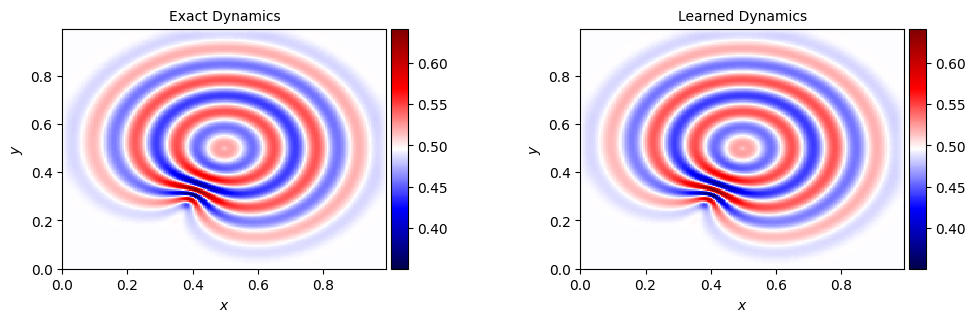

In [ ]:
# Test Data
snap = np.array([180])
x_test = x_star # ((364816, 1)
y_test = y_star # (364816, 1)
t_test = t_star # (364816, 1)
U_test = u_star # (364816, 1)
U_test_scaled = u_star_scaled
dx_test = dx_star # (364816, 1)
dy_test = dy_star # (364816, 1)

# Prediction
u_pred = PINN.predict(x_test,y_test,t_test,dx_test,dy_test)

# u_min = -3.631006664023074e-26
# u_max = 3.703959468272658e-26

# u_pred_scaled = (u_pred - u_min)/(u_max - u_min)

# u_pred = u_pred_scaled

error_u = np.linalg.norm(U_test_scaled-u_pred,2)/np.linalg.norm(U_test_scaled,2)
print('Error w: %e' % (error_u))

u_pred = np.reshape(u_pred,(-1,182))

#-------------------Plotting-----------------------------------------
snap = snap
lb_plot = X_Y_data.min(0)
ub_plot = X_Y_data.max(0)
nn = 200
x_plot = np.linspace(lb_plot[0], ub_plot[0], nn)
y_plot = np.linspace(lb_plot[1], ub_plot[1], nn)
X_plot, Y_plot = np.meshgrid(x_plot,y_plot)

#U_data_plot = griddata(X_Y_data, disp_data[:,snap].flatten(), (X_plot, Y_plot), method='cubic')
U_data_plot = griddata(X_Y_data, scaled_disp_data[:,snap].flatten(), (X_plot, Y_plot), method='cubic')
U_pred_plot = griddata(X_Y_data, u_pred[:,snap].flatten(), (X_plot, Y_plot), method='cubic')

fig, ax = newfig(2.0, 0.6)
ax.axis('off')

########      Exact     ###########
gs = gridspec.GridSpec(1, 3)
gs.update(top=0.8, bottom=0.2, left=0.1, right=0.9, wspace=0.5)
ax = plt.subplot(gs[:, 0])
h = ax.imshow(U_data_plot, interpolation='nearest', cmap='seismic',
              extent=[lb_plot[0], ub_plot[0], lb_plot[1], ub_plot[1]],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('Exact Dynamics', fontsize = 10)

########      Learned      ###########
ax = plt.subplot(gs[:, 1])
h = ax.imshow(U_pred_plot, interpolation='nearest', cmap='seismic',
              extent=[lb_plot[0], ub_plot[0], lb_plot[1], ub_plot[1]],
              origin='lower', aspect='auto')
# h = ax.imshow(np.abs(U_data_plot - U_pred_plot), interpolation='nearest', cmap='seismic',
#               extent=[lb_plot[0], ub_plot[0], lb_plot[1], ub_plot[1]],
#               origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('Forward Learned Dynamics', fontsize = 10)

#######     Error    ###########
ax = plt.subplot(gs[:, 2])
h = ax.imshow(U_data_plot-U_pred_plot, interpolation='nearest', cmap='seismic',
              extent=[lb_plot[0], ub_plot[0], lb_plot[1], ub_plot[1]],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('Parametric Learned Dynamics', fontsize = 10)



plt.savefig('wave2d_scaled_180.png',dpi = 600)
plt.show()